<a id='toc'></a>
# Choosing a Final Model

1. [Setting up the Environment](#envir)
1. [Testing for Significant Difference in Results](#signif)
    1. [F1-Score ANOVA Test](#anova)
    1. [Paired t-tests](#ttest)  

<a id='envir'></a>
# 1. Setting up the Environment

[Return](#toc)

In [ ]:
import numpy as np
import pandas as pd
from numpy import nan as NaN
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

<a id='signif'></a>
# 2. Testing for Significant Difference in Results
Which model is performing the best? 

Logistic Regression has the highest Recall but the lowest F1-Score. Is Logistic Regression's F1-Score statistically different from the other two models?

AdaBoost appears to be outperforming Random Forest on all metrics but is the difference statistically significant?

[Return](#toc)

In [ ]:
# Reading results for significance testing
path = 'C:/Users/X/Documents/A_Documents/Cap_Data/CSV'
LR = pd.read_csv(path+'/results/LR_extras.csv', index_col=0).drop(['Mean'],axis=0)
LR['Model']='Logistic Regression'
RF = pd.read_csv(path+'/results/RF_extras.csv', index_col=0).drop(['Mean'],axis=0)
RF['Model']='Random Forest'
ADA = pd.read_csv(path+'/results/ADA_extras.csv', index_col=0).drop(['Mean'],axis=0)
ADA['Model']='AdaBoost'

#Creating combined dataframe and renaming one column
data = LR.append(RF).append(ADA)
data = data.rename(columns={'F1-Score': 'F1Score'})
# data = data[data['Model']!='Logistic Regression']
# data

<a id='anova'></a>
## A. F1-Score ANOVA Test
Here we will run a One-Way Analysis of Variance (ANOVA), at a 5% significance level,  to test for a difference in F1-Scores.

[Return](#toc)

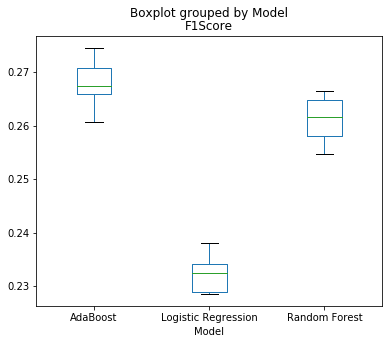

In [5]:
data.boxplot('F1Score', by='Model', figsize=(6,5), grid=False);

In [6]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Creating ANOVA table for F1-Score
mod=ols('F1Score ~ Model', data=data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print('ANOVA table for F1-Score:\n')
print(aov_table)

ANOVA table for F1-Score:

            sum_sq    df           F        PR(>F)
Model     0.007020   2.0  195.111056  8.880799e-17
Residual  0.000486  27.0         NaN           NaN


In [7]:
# Just a quick check using a different stats package...
from scipy import stats

var='F1Score'
one = data[data['Model']=='Logistic Regression'][var]
two = data[data['Model']=='Random Forest'][var]
three = data[data['Model']=='AdaBoost'][var]

stats.f_oneway(one, two, three)

F_onewayResult(statistic=195.11105554154224, pvalue=8.88079913321113e-17)

The above p-value is extremely small and well below 5%. At least one of the F1-Scores is significantly different from another.

<a id='ttest'></a>
## B. Paired t-tests
Here we will run one-tailed paired t-tests, at 5% significance level, to establish if any model's F1-Score is statistically higher than another.

[Return](#toc)

In [8]:
# Testing metrics using paired t-test
from scipy import stats

def sig_test(model1, model2, metric, typ):
    
    X = data[data['Model']==model1][metric]
    Y = data[data['Model']==model2][metric]
    
    # t-test for two indpendent samples
    # print(stats.ttest_ind(one,two, equal_var=True))

    # Paired test
    # test stat from X-Y, two tailed test by default
    # Right tailed (X-Y)>0, test-stat>0 then p-value becomes pvalue/2
    #                       test-stat<0 then p-value becomes 1-pvalue/2
    # Left tailed (X-Y)<0,  test-stat>0 then p=value becomes 1-pvalue/2
    #                       test-stat<0 then p=value becomes pvalue/2 
    
    # H0: Mean of <metric> from model1 =< mean of <metric> from model2
    # Ha: Mean of <metric> from model1  > mean of <metric> from model2
        
    # t-test for paired samples
    stat, p = stats.ttest_rel(X,Y)
    if typ=='greater' and stat>0:
        return (stat, p/2)
    if typ=='greater' and stat<0:
        return (stat, 1-p/2)
    if typ=='lower' and stat>0:
        return (stat, 1-p/2)
    if typ=='lower' and stat<0:
        return (stat, p/2)
    if typ=='different':
        return (stat, p)

In [9]:
# Testing Random Forest against Logistic Regression
print("Testing F1-Score: Is Random Forest significantly higher than Logistic Regression?\nH_0: Random Forest <= Logistic Regression\nH_a: Random Forest > Logistic Regression")
stat, p = sig_test('Random Forest', 'Logistic Regression', 'F1Score', 'greater')
print('t-statistic {:.4f}, p-value: {}'.format(stat,p))

Testing F1-Score: Is Random Forest significantly higher than Logistic Regression?
H_0: Random Forest <= Logistic Regression
H_a: Random Forest > Logistic Regression
t-statistic 27.0509, p-value: 3.1223898635376625e-10


Based on the p-value, which is well below 5% (and well below 5%/3 if a Bonferroni correction is desired), Random Forest's F1-Score is significantly higher than Logistic Regression's F1-Score.

In [10]:
# Testing AdaBoost against Logistic Regression
print("Testing F1-Score: Is AdaBoost significantly higher than Logistic Regression?\nH_0: AdaBoost <= Logistic Regression\nH_a: AdaBoost > Logistic Regression")
stat, p = sig_test('AdaBoost', 'Logistic Regression', 'F1Score', 'greater')
print('t-statistic {:.4f}, p-value: {}'.format(stat,p))

Testing F1-Score: Is AdaBoost significantly higher than Logistic Regression?
H_0: AdaBoost <= Logistic Regression
H_a: AdaBoost > Logistic Regression
t-statistic 40.5877, p-value: 8.329278796488487e-12


Based on the p-value, which is well below 5% (and well below 5%/3 if a Bonferroni correction is desired), AdaBoost's F1-Score is significantly higher than Logistic Regression's F1-Score.

In [11]:
# Testing AdaBoost against Random Forest
print("Testing F1-Score: Is AdaBoost significantly higher than Random Forest?\nH_0: AdaBoost <= Random Forest\nH_a: AdaBoost > Random Forest")
stat, p = sig_test('AdaBoost', 'Random Forest', 'F1Score', 'greater')
print('t-statistic {:.4f}, p-value: {}'.format(stat,p))

Testing F1-Score: Is AdaBoost significantly higher than Random Forest?
H_0: AdaBoost <= Random Forest
H_a: AdaBoost > Random Forest
t-statistic 5.0979, p-value: 0.00032348277550732913


Based on the p-value, which is less than 5% (and less than 5%/3 if a Bonferroni correction is desired), AdaBoost's F1-Score is significantly higher than Random Forest's F1-Score.

Based on F1-Scores, AdaBoost has statistically significant better performance than the other two models.